Install and load required Python packages

In [ ]:
#@title Installation (Python)

!pip install -U tensorflow-addons

import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from keras.preprocessing import sequence
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import sklearn.utils.class_weight as sk_cw

%load_ext tensorboard
%load_ext rpy2.ipython

The R installation might take a few minutes, consider [exporting](https://stackoverflow.com/a/69116838) the installed libraries if you plan to run this notebook more than once.

In [ ]:
%%R
#@title Installation (R)

install.packages("tidymodels")
install.packages("gridExtra")
install.packages("latex2exp")
devtools::install_github('Mikata-Project/ggthemr')

library(tidyverse)
library(tidymodels)
library(grid)
library(gridExtra)
library(ggthemr)
library(latex2exp)

# data_pred is assumed to have the following column:
#  - rating: true class labels
#  - rating_pred: predicted probability of a GOOD rating
metrics_rating_pred <- function(data_pred, ...) {
  
  auc <- data_pred %>%
    mutate(rating_pred = rating_pred) %>%
    roc_auc(truth = rating, rating_pred)
  
  fit_loess <- loess(ratingB ~ rating_pred, 
                   data=(data_pred %>% mutate(ratingB = ifelse(rating == "GOOD", 1, 0))),
                   # Frank Harrell recommends turning off outlier detection in
                   # loess for binary outcomes (Ch2.4)
                   iterations = 1)
  pps <- predict(fit_loess, newdata = data_pred$rating_pred)
  
  ici <- tibble(
    .metric = "ici",
    .estimator = "binary",
    .estimate = mean(abs(pps - data_pred$rating_pred))
  )
  
  emax <- tibble(
    .metric = "Emax",
    .estimator = "binary",
    .estimate = max(abs(pps - data_pred$rating_pred))
  )
  
  N <- length(data_pred$rating_pred)
  base_rate <- sum(data_pred$rating == "GOOD") / length(data_pred$rating_pred)
  resolution <- tibble(
    .metric = "resolution",
    .estimator = "binary",
    .estimate = sum((data_pred$rating_pred - base_rate)^2) / N
  )
  
  bind_rows(
    auc,
    ici,
    emax,
    resolution
  )
  
}

# See metrics_rating_pred function.
# The metrics argument is expected to be the output of metrics_rating_pred.
plot_auc_rating_pred <- function(data_pred, name, metrics, ...) {
  
  auc <- metrics %>%
    filter(.metric == "roc_auc") %>%
    pull(.estimate)
  
  data_pred %>%
    mutate(rating_pred = rating_pred) %>%
    roc_curve(rating, rating_pred) %>%
    ggplot(aes(x = 1 - specificity, y = sensitivity)) +
    geom_path(lwd = 1.5) +
    geom_abline(lty = 3) +
    coord_equal() + 
    theme_minimal() +
    ggtitle(str_interp("${name} - AUC: $[.3f]{auc}"))
  
}

plot_cal_rating_pred <- function(data_pred, name, metrics, ...) {
  
  fit_loess <- loess(ratingB ~ rating_pred,
                     data=(data_pred %>% mutate(ratingB = ifelse(rating == "GOOD", 1, 0))),
                     # Frank Harrell recommends turning off outlier detection in
                     # loess for binary outcomes (Ch2.4)
                     iterations = 1)
  
  ici <- metrics %>%
    filter(.metric == "ici") %>%
    pull(.estimate)
  
  emax <- metrics %>%
    filter(.metric == "Emax") %>%
    pull(.estimate)
  
  # calibration plot
  g1 <- data_pred %>%
    ggplot(aes(x = rating_pred, y = predict(fit_loess))) +
    geom_line(color = "red", lwd=1.5) + 
    scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.1)) +
    scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.1)) +
    geom_abline() + # 45 degree line indicating perfect calibration
    xlab("") +
    ylab("Observed Probability") +
    theme_minimal() +
    ggtitle(str_interp("${name} - ICI: $[.3f]{ici}, Emax: $[.3f]{emax}"))

  # distribution plot        
  g2 <- data_pred %>%
    ggplot(aes(x = rating_pred)) +
    geom_histogram(fill = "black", bins = 200) +
    scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.1)) +
    xlab("Predicted Probability") +
    ylab("") +
    theme_minimal() +
    scale_y_continuous(breaks = c(0, 40)) +
    theme(panel.grid.minor = element_blank())
  
  # combine them    
  g <- arrangeGrob(g1, g2, respect = TRUE, heights = c(1, 0.25), ncol = 1)
  grid.newpage()
  grid.draw(g)
  return(g[[3]])
  
}

Load from Github the first preprocessed subsample of the Swift dataset.
The Github repo containing the code and data is currently private, therefore you need to fill the form below.


In [3]:
# TMP until repo is public
# ref: https://stackoverflow.com/a/62509005

import requests
from io import StringIO

#@markdown Generate a Github token: https://github.com/settings/tokens
github_username='' #@param {type:"string"}
github_token=''  #@param {type:"string"}

github_session = requests.Session()
github_session.auth = (github_username, github_token)

# providing raw url to download csv from github
url_train = 'https://raw.githubusercontent.com/GiacomoRandazzo/memory-models/main/data-swift/1/data_train.csv'
url_test = 'https://raw.githubusercontent.com/GiacomoRandazzo/memory-models/main/data-swift/1/data_test.csv'

download_train = github_session.get(url_train).content
data_train = pd.read_csv(StringIO(download_train.decode('utf-8')))
download_test = github_session.get(url_test).content
data_test = pd.read_csv(StringIO(download_test.decode('utf-8')))

In [4]:
data_train.head()

,rating,intervalDays,idUser,idPrompt
0,0,4,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149
1,0,2,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149
2,0,1,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149
3,1,1,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149
4,1,1,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149


In [5]:
data_test.head()

,rating,intervalDays,idUser,idPrompt
0,1,2,02839E76-A6E1-48E7-A817-13FBC52BCB14,1.1.07-149
1,1,3,02839E76-A6E1-48E7-A817-13FBC52BCB14,1.1.07-149
2,1,2,02839E76-A6E1-48E7-A817-13FBC52BCB14,1.1.07-149
3,1,1,49740A64-594D-49D5-A926-CE16E81705B8,1.2.19-001
4,1,6,49740A64-594D-49D5-A926-CE16E81705B8,1.2.19-001


# DASH[RNN] memory model


## Prepare train data

In [6]:
data_train['idHistory'] = data_train.groupby(['idUser', 'idPrompt']).ngroup()
data_train['isPostLapse'] = data_train.groupby(['idHistory'], group_keys=False).apply(
    lambda x: x.rating.apply(lambda y: 1 - y).shift(periods=1, fill_value=0))
data_train

,rating,intervalDays,idUser,idPrompt,idHistory,isPostLapse
0,0,4,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149,9777,0
1,0,2,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149,9777,1
2,0,1,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149,9777,1
3,1,1,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149,9777,1
4,1,1,F5DB05D3-774D-46DF-B49C-5831FE762258,1.1.07-149,9777,0
...,...,...,...,...,...,...
80411,0,9,9BCB7EBD-EACC-4E5C-8DDC-D4CE53D274D7,2.7.01-123,6245,1
80412,1,4,9BCB7EBD-EACC-4E5C-8DDC-D4CE53D274D7,2.7.01-123,6245,1
80413,0,3,9BCB7EBD-EACC-4E5C-8DDC-D4CE53D274D7,2.7.01-123,6245,0
80414,1,4,9BCB7EBD-EACC-4E5C-8DDC-D4CE53D274D7,2.7.01-123,6245,1


In [7]:
user = data_train[["idHistory", "idUser"]].groupby("idHistory").first()
x_train_user = user.to_numpy()
print(f'x_train_user shape: {np.shape(x_train_user)}')

card = data_train[["idHistory", "idPrompt"]].groupby("idHistory").first()
x_train_card = card.to_numpy()
print(f'x_train_card shape: {np.shape(x_train_card)}')

x_train_user shape: (10000, 1)
x_train_card shape: (10000, 1)


In [8]:
sequences = data_train[["idHistory", "rating", "intervalDays", "isPostLapse"]]

sequences_wide = sequences.groupby('idHistory').apply(pd.Series.tolist)

np.array([len(x) for x in sequences_wide])
max_history_length = np.array([len(x) for x in sequences_wide]).max()
print(f'Max history length: {max_history_length}')

sequences_wide_np = sequences_wide.to_numpy()

# pad data
value_pad = -1
sequences_wide_np = sequence.pad_sequences(sequences_wide_np, 
                                            maxlen=max_history_length, 
                                            padding="post", 
                                            value=value_pad,
                                            dtype='float32')

# remove idHistory
sequences_wide_np = np.delete(sequences_wide_np, 0, 2)

x_train_sequences = np.delete(sequences_wide_np, [0], 2)
y_train = np.expand_dims(sequences_wide_np[:,:,0], axis=2)

print(f'x_train_sequences shape: {np.shape(x_train_sequences)}; y_train shape: {np.shape(y_train)}')

cnt_success = y_train[y_train > -1].sum()
cnt_total = len(y_train[y_train > -1])
cnt_failure = cnt_total - cnt_success
prop_success = cnt_success / cnt_total
print(f'Sequences training set proportion of successful reviews: {prop_success}')

Max history length: 62
x_train_sequences shape: (10000, 62, 2); y_train shape: (10000, 62, 1)
Sequences training set proportion of successful reviews: 0.7861370871468365


## Prepare test data

In [9]:
data_test['idHistory'] = data_test.groupby(['idUser', 'idPrompt']).ngroup()
data_test['isPostLapse'] = data_test.groupby(['idHistory'], group_keys=False).apply(
    lambda x: x.rating.apply(lambda y: 1 - y).shift(periods=1, fill_value=0))
data_test

,rating,intervalDays,idUser,idPrompt,idHistory,isPostLapse
0,1,2,02839E76-A6E1-48E7-A817-13FBC52BCB14,1.1.07-149,38,0
1,1,3,02839E76-A6E1-48E7-A817-13FBC52BCB14,1.1.07-149,38,0
2,1,2,02839E76-A6E1-48E7-A817-13FBC52BCB14,1.1.07-149,38,0
3,1,1,49740A64-594D-49D5-A926-CE16E81705B8,1.2.19-001,1180,0
4,1,6,49740A64-594D-49D5-A926-CE16E81705B8,1.2.19-001,1180,0
...,...,...,...,...,...,...
40505,1,1,AE480590-CE72-4344-B329-F59010534E0E,2.1.08-014,3516,0
40506,1,2,AE480590-CE72-4344-B329-F59010534E0E,2.1.08-014,3516,0
40507,1,3,AE480590-CE72-4344-B329-F59010534E0E,2.1.08-014,3516,0
40508,1,4,AE480590-CE72-4344-B329-F59010534E0E,2.1.08-014,3516,0


In [10]:
user = data_test[["idHistory", "idUser"]].groupby("idHistory").first()
x_test_user = user.to_numpy()
print(f'x_test_user shape: {np.shape(x_test_user)}')

card = data_test[["idHistory", "idPrompt"]].groupby("idHistory").first()
x_test_card = card.to_numpy()
print(f'x_test_card shape: {np.shape(x_test_card)}')

x_test_user shape: (5000, 1)
x_test_card shape: (5000, 1)


In [11]:
sequences = data_test[["idHistory", "rating", "intervalDays", "isPostLapse"]]

sequences_wide = sequences.groupby('idHistory').apply(pd.Series.tolist)
sequences_wide_np = sequences_wide.to_numpy()
sequences_wide_np = sequence.pad_sequences(sequences_wide_np, 
                                            maxlen=max_history_length, 
                                            padding="post", 
                                            value=value_pad,
                                            dtype='float32')
sequences_wide_np = np.delete(sequences_wide_np, 0, 2)

x_test_sequences = np.delete(sequences_wide_np, [0], 2)
# x_test_sequences = np.delete(sequences_wide_np, [0], 2)
y_test = np.expand_dims(sequences_wide_np[:,:,0], axis=2)

print(f'x_test_sequences shape: {np.shape(x_test_sequences)}; y_test shape: {np.shape(y_test)}')

x_test_sequences shape: (5000, 62, 2); y_test shape: (5000, 62, 1)


## Define and fit model

Set a random seed

In [12]:
np.random.seed(11042022)
tf.keras.utils.set_random_seed(11042022)

Set the initial value for the bias of the output neuron in order to speed up training

In [13]:
output_bias = np.log([cnt_success/cnt_failure])
print(f'Initial output bias: {output_bias}; cnt_success: {cnt_success}; cnt_failure: {cnt_failure}; cnt_total:{cnt_total}')

Initial output bias: [1.30179597]; cnt_success: 63218.0; cnt_failure: 17198.0; cnt_total:80416


Define the DASH[RNN] model

In [14]:
K.clear_session()

units_dense = 12
units_hidden_state = 5


inputs_sequences = layers.Input(shape=(max_history_length, 2), name="inputs_sequences")
masked_sequences = layers.Masking(mask_value=value_pad, input_shape=(max_history_length, 2))(inputs_sequences)

dense1 = layers.TimeDistributed(layers.Dense(units_dense, activation='relu'))(masked_sequences)
dense2 = layers.TimeDistributed(layers.Dense(units_dense, activation='relu'))(dense1)

rnn = layers.SimpleRNN(units_hidden_state, activation='relu', return_sequences=True)(dense2)

input_user = layers.Input(shape=(1), name="input_user", dtype="string")
layer_onehot_user = tf.keras.layers.StringLookup(output_mode='one_hot')
layer_onehot_user.adapt(x_train_user)
onehot_user = layer_onehot_user(input_user)
repeated_onehot_user = layers.RepeatVector(max_history_length.item())(onehot_user)

input_card = layers.Input(shape=(1), name="input_card", dtype="string")
layer_onehot_card = tf.keras.layers.StringLookup(output_mode='one_hot')
layer_onehot_card.adapt(x_train_card)
onehot_card = layer_onehot_card(input_card)
repeated_onehot_card = layers.RepeatVector(max_history_length.item())(onehot_card)

concatenated = layers.concatenate([rnn, repeated_onehot_user, repeated_onehot_card])

output = layers.TimeDistributed(layers.Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(output_bias), name="sigmoid_out"))(concatenated)


model_0 = keras.Model(inputs=[inputs_sequences, input_user, input_card], outputs=output, name="model_r17_simple")
model_0.summary()

Model: "model_r17_simple"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs_sequences (InputLayer)  [(None, 62, 2)]      0           []                               
                                                                                                  
 masking (Masking)              (None, 62, 2)        0           ['inputs_sequences[0][0]']       
                                                                                                  
 time_distributed (TimeDistribu  (None, 62, 12)      36          ['masking[0][0]']                
 ted)                                                                                             
                                                                                                  
 input_user (InputLayer)        [(None, 1)]          0           []                

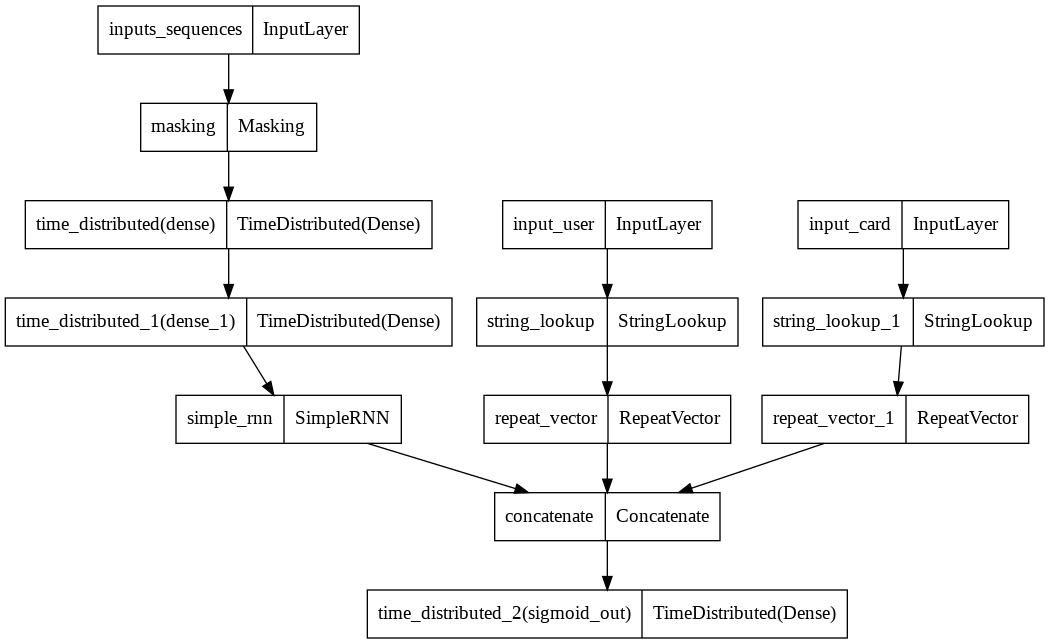

In [15]:
keras.utils.plot_model(model_0)

Training parameters

In [16]:
EPOCHS = 50
BATCH_SIZE = 128

INIT_LR = 3e-4
MAX_LR = 1e-2

In [17]:
def scale_fn(x):
  return 1/(2.**(x-1))
steps_per_epoch = np.ceil(np.shape(x_train_sequences)[0]/BATCH_SIZE)
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate = INIT_LR,
    maximal_learning_rate = MAX_LR,
    scale_fn = scale_fn,
    step_size = 8 * steps_per_epoch
)

model_0.compile(optimizer = tf.optimizers.Adam(clr),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.AUC()])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

Optionally run TensorBoard

In [ ]:
%tensorboard --logdir logs/fit/

Evaluate pre-training loss

In [19]:
results_pre = model_0.evaluate([x_train_sequences, x_train_user, x_train_card], y_train, batch_size=128, verbose=0)
print("Loss: {:0.4f}".format(results_pre[0]))

Loss: 0.0218


In [20]:
model_0.fit([x_train_sequences, x_train_user, x_train_card], y_train, 
            epochs=EPOCHS, 
            batch_size=BATCH_SIZE,
            callbacks=[tensorboard_callback])

Epoch 1/50
79/79 [==============================] - 13s 141ms/step - loss: 0.0216 - auc: 0.6202
Epoch 2/50
79/79 [==============================] - 11s 135ms/step - loss: 0.0198 - auc: 0.7731
Epoch 3/50
79/79 [==============================] - 11s 137ms/step - loss: 0.0168 - auc: 0.8212
Epoch 4/50
79/79 [==============================] - 11s 142ms/step - loss: 0.0158 - auc: 0.8440
Epoch 5/50
79/79 [==============================] - 11s 143ms/step - loss: 0.0153 - auc: 0.8529
Epoch 6/50
79/79 [==============================] - 11s 136ms/step - loss: 0.0151 - auc: 0.8564
Epoch 7/50
79/79 [==============================] - 11s 137ms/step - loss: 0.0147 - auc: 0.8633
Epoch 8/50
79/79 [==============================] - 11s 135ms/step - loss: 0.0145 - auc: 0.8665
Epoch 9/50
79/79 [==============================] - 11s 134ms/step - loss: 0.0143 - auc: 0.8703
Epoch 10/50
79/79 [==============================] - 11s 136ms/step - loss: 0.0142 - auc: 0.8723
Epoch 11/50
79/79 [====================

## Evaluation

In [21]:
predictions = model_0.predict([x_test_sequences, x_test_user, x_test_card])

predictions_r = predictions[y_test > -1].flatten()
y_test_r = y_test[y_test > -1].flatten()

print(f'predictions_r shape: {np.shape(predictions_r)}; y_test_r shape: {np.shape(y_test_r)}')

np_predictions = np.concatenate((np.array(y_test_r).reshape(-1, 1), predictions_r.reshape(-1, 1)), axis=1)
df_predictions = pd.DataFrame(data=np_predictions, columns=["rating", "rating_pred"])
df_predictions.head()

predictions_r shape: (40510,); y_test_r shape: (40510,)


,rating,rating_pred
0,0.0,0.337829
1,0.0,0.401319
2,0.0,0.449314
3,0.0,0.453563
4,1.0,0.460967


In [22]:
%%R -i df_predictions

r_predictions <- df_predictions %>% mutate(rating = factor(ifelse(rating == 1, "GOOD", "AGAIN"), levels = c("GOOD", "AGAIN")))
metrics <- metrics_rating_pred(r_predictions)
metrics

# A tibble: 4 × 3
  .metric    .estimator .estimate
  <chr>      <chr>          <dbl>
1 roc_auc    binary       0.867  
2 ici        binary       0.00605
3 Emax       binary       0.0114 
4 resolution binary       0.0573 


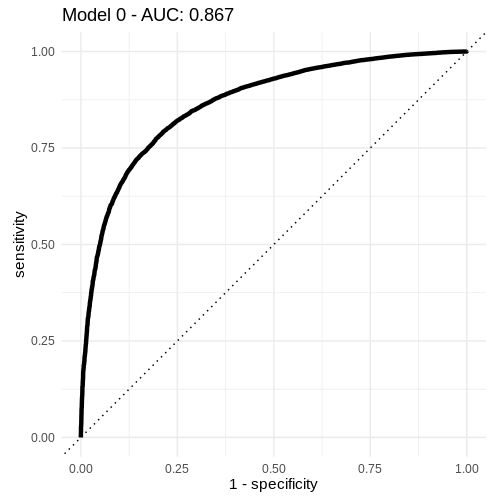

In [23]:
%%R -i df_predictions -w 5 -h 5 --units in -r 100

plot_auc_rating_pred(r_predictions, "Model 0", metrics)

[1] 1null


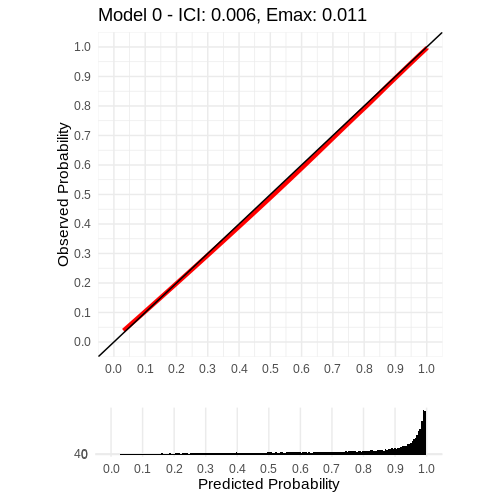

In [24]:
%%R -i df_predictions -w 5 -h 5 --units in -r 100

plot_cal_rating_pred(r_predictions, "Model 0", metrics)

## Forgetting curves

In [25]:
xs = np.linspace(1., 60., num=1000)

u = "7C0EB3F8-3D9A-42D1-A1B9-2CD762392296"
c = "2.6.06-213"

x_sequences_11 = sequence.pad_sequences([[ [1.,0], [5.,0], [x,0]] for x in xs], 
                        maxlen=62, 
                        padding="post", 
                        value=-1,
                        dtype='float32')

x_sequences_01 = sequence.pad_sequences([[ [1.,0], [5.,0], [x,1]] for x in xs], 
                        maxlen=62, 
                        padding="post", 
                        value=-1,
                        dtype='float32')

x_sequences_10 = sequence.pad_sequences([[ [1.,0], [5.,1], [x,0]] for x in xs], 
                        maxlen=62, 
                        padding="post", 
                        value=-1,
                        dtype='float32')

x_user = np.array([[u] for _ in range(0, 1000)])
x_card = np.array([[c] for _ in range(0, 1000)])

preds_11 = model_0.predict([x_sequences_11, x_user, x_card])
preds_01 = model_0.predict([x_sequences_01, x_user, x_card])
preds_10 = model_0.predict([x_sequences_10, x_user, x_card])

ys_11 = preds_11[:, 2:3, :].flatten()
ys_01 = preds_01[:, 2:3, :].flatten()
ys_10 = preds_10[:, 2:3, :].flatten()

df = pd.DataFrame(np.column_stack((xs, ys_11, ys_01, ys_10)), 
                  columns=["xs", "ys11", "ys01", "ys10"])

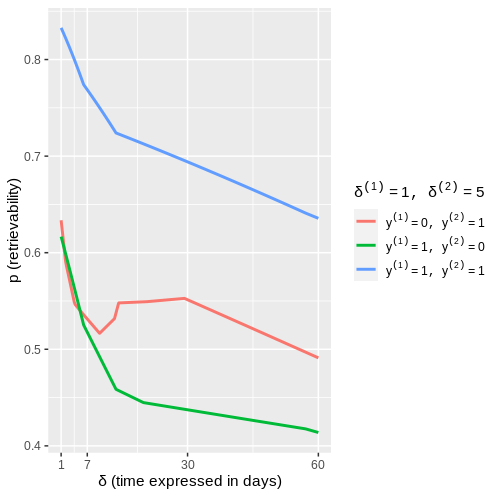

In [26]:
%%R -i df -w 5 -h 5 --units in -r 100

as_tibble(df) %>%
  mutate(
      xs=as.numeric(xs), 
      ys11=as.numeric(ys11),
      ys10=as.numeric(ys10),
      ys01=as.numeric(ys01),
  ) %>%
  pivot_longer(!xs, names_to = "fc", values_to = "ys") %>%
  ggplot(aes(x = xs, y = ys, col=fc)) +
  geom_line(size=1) + 
  scale_x_continuous(breaks=c(1,7,30,60)) + 
  ylab("p (retrievability)") + 
  xlab(TeX("$\\delta$ (time expressed in days)")) +
  labs(col = TeX("$\\delta^{(1)} = 1, \\delta^{(2)} = 5$")) +
  scale_color_discrete(labels = c(TeX("$y^{(1)} = 0, y^{(2)} = 1$"), TeX("$y^{(1)} = 1, y^{(2)} = 0$"), TeX("$y^{(1)} = 1, y^{(2)} = 1$")))